In [1]:
import pandas as pd

# dataset_url = "https://git.io/nlp-with-transformers"
dataset_url = "https://raw.githubusercontent.com/nlp-with-transformers/notebooks/main/data/github-issues-transformers.jsonl"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"DataFrame shape: {df_issues.shape}")

DataFrame shape: (9930, 26)


In [2]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()


,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [3]:
df_issues["labels"] = (df_issues["labels"]
                       .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [4]:
df_issues["labels"].apply(lambda x : len(x)).value_counts().to_frame().T

labels,0,1,2,3,4,5
count,6440,3057,305,100,25,3


In [5]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
# display the top-8 label categories
df_counts.to_frame().head(8).T

Number of labels: 65


labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
count,2284,649,106,98,64,52,50,46


In [6]:
label_map = {
    "Core: Tokenization": "tokenization",
    "New model": "new model",
    "Core: Modeling": "model training",
    "Usage": "usage",
    "Core: Pipeline": "pipeline",
    "TensorFlow": "tensorflow or tf",
    "PyTorch": "pytorch",
    "Examples": "examples",
    "Documentation": "documentation"}

def filter_labels(x):
  return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())


In [7]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
count,106,98,64,46,42,41,37,28,24


In [8]:
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,count
split,
unlabeled,9489
labeled,441


In [9]:
for column in ["title", "body", "labels"]:
  print(f"{column}: {df_issues[column].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [10]:
df_issues["text"] = (df_issues
                     .apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

In [11]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"Removed {(len_before-len(df_issues))/len_before:.2%} duplicates.")

Removed 1.88% duplicates.


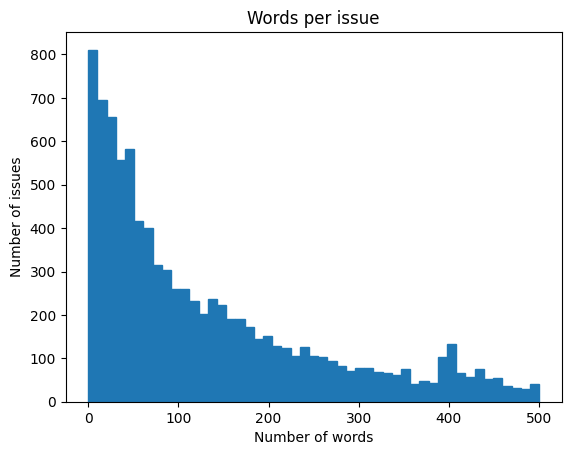

In [12]:
import numpy as np 
import matplotlib.pyplot as plt

(df_issues["text"].str.split().apply(len)
 .hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0"))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [14]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
  ind = np.expand_dims(np.arange(len(df)), axis=1)
  labels = mlb.transform(df["labels"])
  ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, 
                                                         test_size)
  return df.iloc[ind_train[:,0]], df.iloc[ind_test[:,0]]

In [15]:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [16]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)), 
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)), 
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)), 
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

In [17]:
np.random.seed(0)

all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
  # split off samples necessary to fill the gap to the next split size
  indices_pool, labels, new_slice, _ = iterative_train_test_split(
      indices_pool, labels, (k-last_k)/len(labels))
  last_k = k
  if i==0: train_slices.append(new_slice)
  else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# add full dataset as last slice
train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [18]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


In [19]:
assert 0 == 1

AssertionError: 

**Implement a Naive Bayesline**

In [28]:
def prepare_labels(batch):
  batch["label_ids"] = mlb.transform(batch["labels"])
  return batch

ds = ds.map(prepare_labels, batched=True)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [ ]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
  # Get training slice and test data
  ds_train_sample = ds["train"].select(train_slice)
  y_train = np.array(ds_train_sample["label_ids"])
  y_test = np.array(ds["test"]["label_ids"])
  # Use a simple count vectorizer to encode our texts as token counts
  count_vect = CountVectorizer()
  X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
  X_test_counts = count_vect.transform(ds["test"]["text"])
  # Create and train our model!
  classifier = BinaryRelevance(classifier=MultinomialNB())
  classifier.fit(X_train_counts, y_train)
  # Generate predictions and evaluate
  y_pred_test = classifier.predict(X_test_counts)
  clf_report = classification_report(
  y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
  output_dict=True)
  # Store metrics
  macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
  micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

In [43]:
import matplotlib.pyplot as plt 

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
  
  for run in micro_scores.keys():
    if run == current_model:
      ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
      ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
    else:
      ax0.plot(sample_sizes, micro_scores[run], label=run, 
               linestyle="dashed")
      ax1.plot(sample_sizes, macro_scores[run], label=run, 
               linestyle="dashed")

  ax0.set_title("Micro F1 scores")
  ax1.set_title("Macro F1 scores")
  ax0.set_ylabel("Test set F1 score")
  ax0.legend(loc="lower right")
  for ax in [ax0, ax1]:
    ax.set_xlabel("Number of training samples")
    ax.set_xscale("log")
    ax.set_xticks(sample_sizes)
    ax.set_xticklabels(sample_sizes)
    ax.minorticks_off()
  plt.tight_layout()
  plt.show()

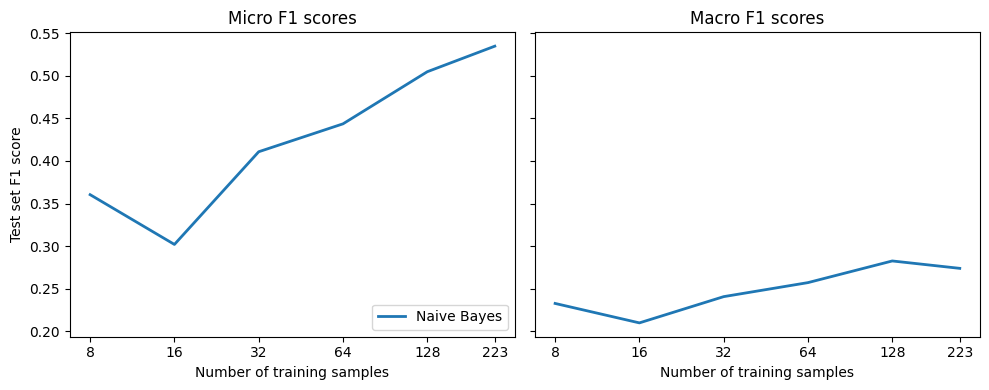

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

**Working with No Labeled Data**

In [ ]:
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
movie_desc = "The main characters of the movie madacascar \
    are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."
output = pipe(movie_desc + prompt)
for element in output:
  print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:	0.103%
Token lions:	0.066%
Token birds:	0.025%
Token love:	0.015%
Token hunting:	0.013%


In [ ]:
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
  print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:	0.103%
Token cars:	0.001%


In [ ]:
movie_desc = "In the movie transformers aliens \
    can morph into a wide range of vehicles."
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
  print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token cars:	0.139%
Token animals:	0.006%


In [ ]:
import torch
from transformers import pipeline

pipe = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
sample = ds["train"][0]
print(f"Labels: {sample['labels']}")
output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\nPredictions")

for label, score in zip(output["labels"], output["scores"]):
  print(f"{label}, {score:.2f}")

Labels: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokeni

Predictions
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


In [ ]:
def zero_shot_pipeline(example):
  output = pipe(example["text"], all_labels, multi_label=True)
  example["predicted_labels"] = output["labels"]
  example["score"] = output["scores"]
  return example

ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

/home/jim/anaconda3/envs/cvml/lib/python3.9/site-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
def get_preds(example, threshold=None, topk=None):
  preds = []
  if threshold:
    for label, score in zip(example["predicted_labels"], example["score"]):
      if score >= threshold:
        preds.append(label)
  elif topk:
    for i in range(topk):
      preds.append(example["predicted_labels"][i])
  else:
    raise ValueError("Set either `threshold` or `topk`.")
  return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

In [ ]:
def get_clf_report(ds):
  y_true = np.array(ds["label_ids"])
  y_pred = np.array(ds["pred_label_ids"])
  return classification_report(
      y_true, y_pred, target_names=mlb.classes_, zero_division=0, 
      output_dict=True)

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

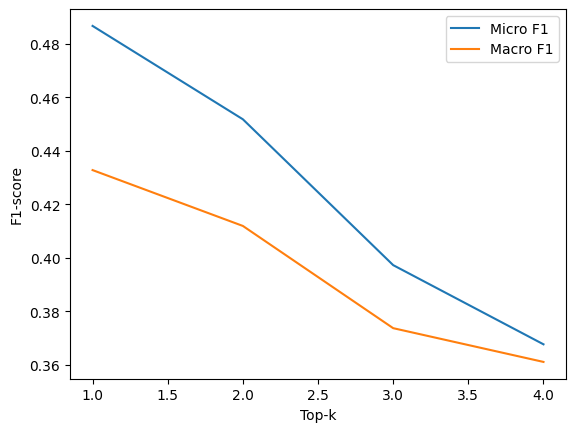

In [ ]:
macros, micros = [], []
topks = [1, 2, 3, 4]
for topk in topks:
  ds_zero_shot = ds_zero_shot.map(get_preds, batched=False,
                                  fn_kwargs={'topk': topk})
  clf_report = get_clf_report(ds_zero_shot)
  micros.append(clf_report['micro avg']['f1-score'])
  macros.append(clf_report['macro avg']['f1-score'])

plt.plot(topks, micros, label='Micro F1')
plt.plot(topks, macros, label='Macro F1')
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()
  

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

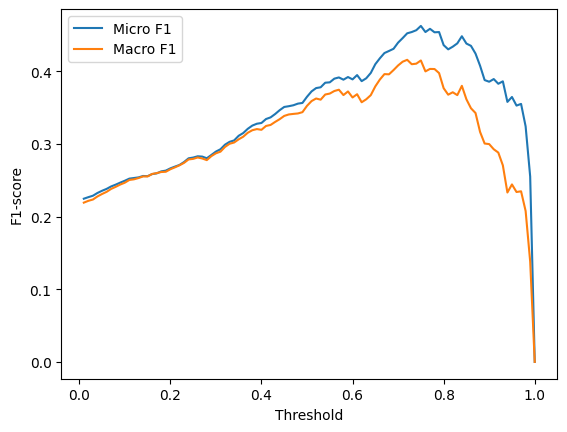

In [ ]:
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
  ds_zero_shot = ds_zero_shot.map(get_preds, 
                                  fn_kwargs={"threshold": threshold})
  clf_report = get_clf_report(ds_zero_shot)
  micros.append(clf_report["micro avg"]["f1-score"])
  macros.append(clf_report["macro avg"]["f1-score"])

plt.plot(thresholds, micros, label='Micro F1')
plt.plot(thresholds, macros, label='Macro F1')
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

In [ ]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (macro): {best_t} with F1-score {best_macro:.2f}.')


Best threshold (micro): 0.75 with F1-score 0.46.
Best threshold (macro): 0.72 with F1-score 0.42.


In [ ]:
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk': 1})

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

/home/jim/anaconda3/envs/cvml/lib/python3.9/site-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Map:   0%|          | 0/111 [00:00<?, ? examples/s]

In [ ]:
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices:
  micro_scores['Zero Shot'].append(clf_report['micro avg']['f1-score'])
  macro_scores['Zero Shot'].append(clf_report['macro avg']['f1-score'])

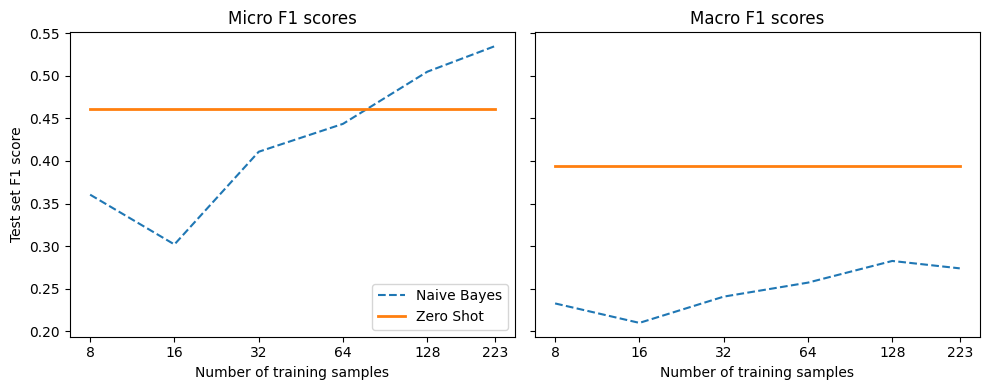

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Zero Shot")

**Working with a Few Labels**

In [ ]:
from transformers import set_seed
import nlpaug.augmenter.word as naw

set_seed(3)
aug = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased",
                                device="cuda", action="substitute")

text = "Transformers are the most popular toys"
print(f"Original text: {text}")
print(f"Augmented text: {aug.augment(text)}")

Original text: Transformers are the most popular toys
Augmented text: ['transformers produce the most famous toys']


In [ ]:
def augment_text(batch, transformations_per_example=1):
  text_aug, label_ids = [], []
  for text, labels in zip(batch["text"], batch["label_ids"]):
    text_aug += [text]
    label_ids += [labels]
    for _ in range(transformations_per_example):
      text_aug += aug.augment(text)
      label_ids += [labels]
  return {"text": text_aug, "label_ids": label_ids}

In [ ]:
for train_slice in train_slices:
  # Get training slice and test data
  ds_train_sample = ds["train"].select(train_slice)
  ds_train_sample = ds_train_sample.map(augment_text, batched=True, 
    remove_columns=ds_train_sample.column_names).shuffle(seed=42)
  y_train = np.array(ds_train_sample["label_ids"])
  y_test = np.array(ds["test"]["label_ids"])
  # Use a simple count vectorizer to encode our texts as token counts
  count_vect = CountVectorizer()
  X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
  X_test_counts = count_vect.transform(ds["test"]["text"])
  # Create and train our model!
  classifier = BinaryRelevance(classifier=MultinomialNB())
  classifier.fit(X_train_counts, y_train)
  # Generate predictions and evaluate
  y_pred_test = classifier.predict(X_test_counts)
  clf_report = classification_report(
  y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
  output_dict=True)
  # Store metrics
  macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
  micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

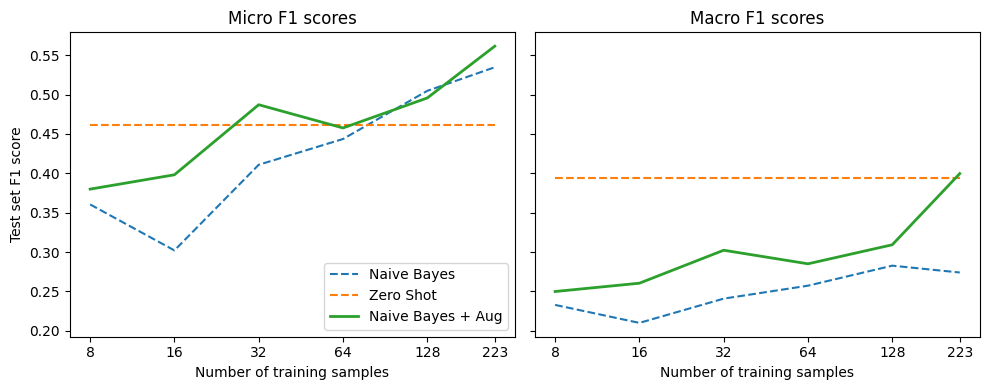

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

**Using Embeddings as a Lookup Table**

In [20]:
import torch 
from transformers import AutoTokenizer, AutoModel

model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

devide = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(devide)

Some weights of the model checkpoint at miguelvictor/python-gpt2-large were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


GPT2Model(
  (wte): Embedding(50257, 1280)
  (wpe): Embedding(1024, 1280)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-35): 36 x GPT2Block(
      (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
)

In [21]:
def mean_pooling(model_output, attention_mask):
  # extract the token embeddings
  token_embeddings = model_output[0]
  # compute the attention mask
  input_mask_expanded = (attention_mask
                         .unsqueeze(-1)
                         .expand(token_embeddings.size())
                         .float())
  # sum the embeddings, but ignore masked tokens
  sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
  sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
  # return the average as a single vector
  return sum_embeddings / sum_mask

def embed_text(examples):
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  inputs = tokenizer(examples["text"], padding=True, truncation=True,
                     max_length=128, return_tensors="pt").to(device)
  with torch.no_grad():
    model_output = model(**inputs)
  pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
  return {"embedding": pooled_embeds.cpu().numpy()}

In [30]:
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

In [32]:
embs_train.add_faiss_index("embedding")

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'labels', 'label_ids', 'embedding'],
    num_rows: 223
})

In [33]:
import numpy as np

i, k = 0, 3 # select the first query and 3 nearest neighbors
rn, nl = "\r\n\r\n", "\n" # used to remove newlines in text for compact display

query = np.array(embs_valid[i]["embedding"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)

print(f"QUERY LABELS: {embs_valid[i]['labels']}")
print(f"QUERY TEXT:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n")
print("="*50)
print(f"Retrieved documents:")
for score, label, text in zip(scores, samples["labels"], samples["text"]):
  print("="*50)
  print(f"TEXT:\n{text[:200].replace(rn, nl)} [...]")
  print(f"SCORE: {score:.2f}")
  print(f"LABELS: {label}")

QUERY LABELS: ['new model']
QUERY TEXT:
Implementing efficient self attention in T5

# 🌟 New model addition
My teammates and I (including @ice-americano) would like to use efficient self attention methods such as Linformer, Performer and [...]

Retrieved documents:
TEXT:
Add Linformer model

# 🌟 New model addition
## Model description
### Linformer: Self-Attention with Linear Complexity
Paper published June 9th on ArXiv: https://arxiv.org/abs/2006.04768
La [...]
SCORE: 54.92
LABELS: ['new model']
TEXT:
Add FAVOR+ / Performer attention

# 🌟 FAVOR+ / Performer attention addition
Are there any plans to add this new attention approximation block to Transformers library?
## Model description
The n [...]
SCORE: 57.90
LABELS: ['new model']
TEXT:
Implement DeLighT: Very Deep and Light-weight Transformers

# 🌟 New model addition
## Model description
DeLight, that delivers similar or better performance than transformer-based models with sign [...]
SCORE: 60.12
LABELS: ['new model']


In [39]:
from sklearn.metrics import classification_report

def get_sample_preds(sample, m):
  return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
  max_k = min(len(ds_train), max_k)
  perf_micro = np.zeros((max_k, max_k))
  perf_macro = np.zeros((max_k, max_k))
  for k in range(1, max_k):
    for m in range(1, k + 1):
      _, samples = ds_train.get_nearest_examples_batch("embedding", 
                                                       valid_queries, k=k)
      y_pred = np.array([get_sample_preds(s, m) for s in samples])
      clf_report = classification_report(valid_labels, y_pred,
                                         target_names=mlb.classes_,
                                         zero_division=0, output_dict=True)
      perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
      perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
  return perf_micro, perf_macro

In [40]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

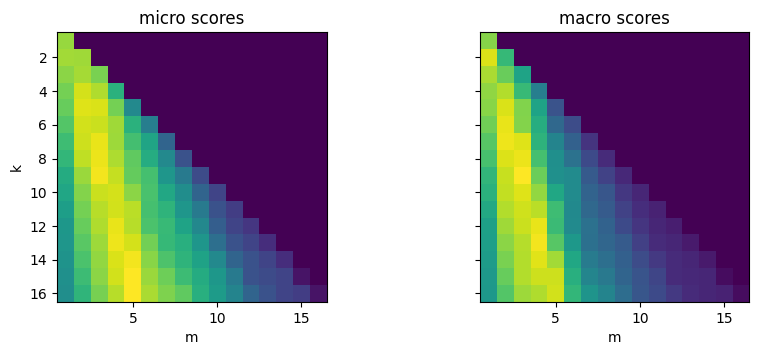

In [41]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro) 

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
  ax.set_xlim([0.5, 17 - 0.5])
  ax.set_ylim([17 - 0.5, 0.5])
  ax.set_xlabel("m")
plt.show()

In [42]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"Best k: {k}, best m: {m}")

Best k: 15, best m: 5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

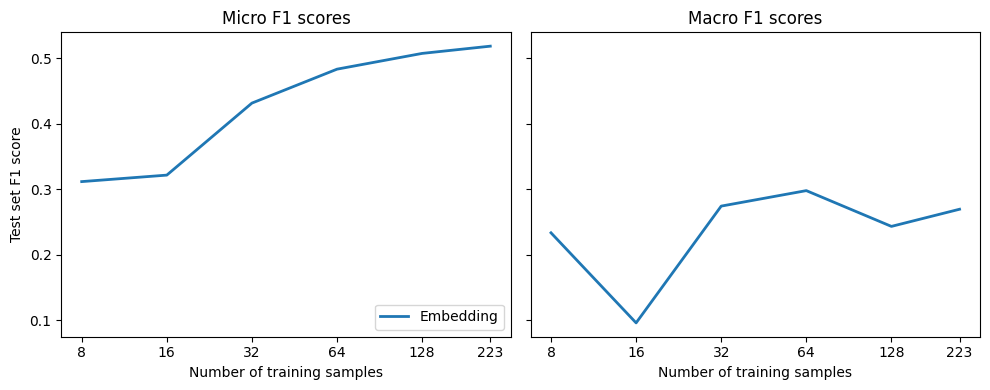

In [46]:
from collections import defaultdict
macro_scores = defaultdict(list)
micro_scores = defaultdict(list)

embs_train.drop_index("embedding")
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
  # create a faiss index from training slice
  embs_train_tmp = embs_train.select(train_slice)
  embs_train_tmp.add_faiss_index("embedding")
  # get best k, m values with validation set
  perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
  k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
  # get predictions on test set
  _, samples = embs_train_tmp.get_nearest_examples_batch("embedding",
                                                         test_queries,
                                                         k=int(k))
  y_pred = np.array([get_sample_preds(s, m) for s in samples])
  # evaluate predictions
  clf_report = classification_report(test_labels, y_pred, 
                                     target_names=mlb.classes_, zero_division=0,
                                     output_dict=True)
  macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
  micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")

**Fine-Tuning a Vanilla Transformer**

In [49]:
import torch
from transformers import (AutoTokenizer, AutoConfig,
                          AutoModelForSequenceClassification)

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
  return tokenizer(batch["text"], truncation=True, max_length=128)

ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(['labels', 'text'])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [50]:
ds_enc.set_format("torch")
ds_enc = ds_enc.map(lambda x: {"label_ids_f": x["label_ids"].to(torch.float)}, 
                    remove_columns=["label_ids"])
ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [ ]:
from transformers import Trainer, TrainingArguments

training_args_fine_tune = TrainingArguments(
  output_dir="./results", num_train_epochs=20, learning_rate=3e-5, 
  lr_scheduler_type='constant', per_device_train_batch_size=4, 
  per_device_eval_batch_size=32, weight_decay=0.0,
  evaluation_strategy="epoch", save_strategy="epoch", logging_strategy="epoch",
  load_best_model_at_end=True, metric_for_best_model='micro f1', 
  save_total_limit=1, log_level='error')


In [56]:
from scipy.special import expit as sigmoid

def compute_metrics(pred):
  y_true = pred.label_ids
  y_pred = sigmoid(pred.predictions)
  y_pred = (y_pred>0.5).astype(float)
  
  clf_dict = classification_report(y_true, y_pred, target_names=all_labels,
                                   zero_division=0, output_dict=True)
  return {"micro f1": clf_dict["micro avg"]["f1-score"], 
          "macro f1": clf_dict["macro avg"]["f1-score"]}

In [ ]:
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

for train_slice in train_slices:
  model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, 
                                                             config=config)
  trainer = Trainer(
    model=model, tokenizer=tokenizer,
    args=training_args_fine_tune, 
    compute_metrics=compute_metrics, 
    train_dataset=ds_enc["train"].select(train_slice),
    eval_dataset=ds_enc["valid"])
  
  trainer.train()
  pred = trainer.predict(ds_enc["test"])
  metrics = compute_metrics(pred)
  macro_scores["Fine-tune (vanila)"].append(metrics["macro f1"])
  micro_scores["Fine-tune (vanila)"].append(metrics["micro f1"])

plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")

`See page 287 for results`

In [58]:
def tokenize(batch):
  return tokenizer(batch["text"], truncation=True,
                   max_length=128, return_special_tokens_mask=True)

ds_mlm = ds.map(tokenize, batched=True)
ds_mlm = ds_mlm.remove_columns(["labels", "text", "label_ids"])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [59]:
from transformers import DataCollatorForLanguageModeling, set_seed 

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, 
                                                mlm_probability=0.15)
                                                

In [61]:
set_seed(3)
data_collator.return_tensors = "np"
inputs = tokenizer("Transformers are awesome!", return_tensors="np")
outputs = data_collator([{"input_ids": inputs["input_ids"][0]}])

pd.DataFrame({
    "Original tokens": tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]),
    "Masked tokens": tokenizer.convert_ids_to_tokens(outputs["input_ids"][0]),
    "Original input_ids": inputs["input_ids"][0],
    "Masked input_ids": outputs["input_ids"][0],
    "Labels": outputs["labels"][0]}).T

,0,1,2,3,4,5
Original tokens,[CLS],transformers,are,awesome,!,[SEP]
Masked tokens,[CLS],transformers,are,awesome,[MASK],[SEP]
Original input_ids,101,19081,2024,12476,999,102
Masked input_ids,101,19081,2024,12476,103,102
Labels,-100,-100,-100,-100,999,-100


In [62]:
data_collator.return_tensors = "pt"

In [ ]:
from transformers import AutoModelForMaskedLM 

training_args = TrainingArguments(
    output_dir = f"{model_ckpt}-issues-128", per_device_train_batch_size=32,
    logging_strategy="epoch", evaluation_strategy="epoch", save_strategy="no",
    num_train_epochs=16, push_to_hub=False, log_level="error", report_to="none")

trainer = Trainer(
    model=AutoModelForMaskedLM.from_pretrained("bert-base-uncased"),
    tokenizer=tokenizer, args=training_args, data_collator=data_collator,
    train_dataset=ds_mlm["unsup"], eval_dataset=ds_mlm["train"])

trainer.train()

In [ ]:
df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"].plot(
    label="Validation"))
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()



In [65]:
model_ckpt = f'transformersbook/bert-base-uncased-issues-128'
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

In [ ]:
for train_slice in train_slices:
  model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, 
                                                             config=config)
  
  trainer = Trainer(
      model=model,
      tokenizer=tokenizer,
      args=training_args_fine_tune,
      compute_metrics=compute_metrics,
      train_dataset=ds_enc["train"].select(train_slice),
      eval_dataset=ds_enc["valid"],
  )
  
  trainer.train()
  pred = trainer.predict(pred)
  metrics = compute_metrics(pred)
  # DA refers to domain adaptation
  macro_scores["Fine-tune (DA)"].append(metrics["macro f1"])
  micro_scores["Fine-tune (DA)"].append(metrics["micro f1"])

plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (DA)")
# See page 294 for results